# *Importing Libraries:*

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import copy
import timm

import torch
import torch.nn as nn
from torch.optim import Adam, Adamax, lr_scheduler
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import datasets, transforms

from tqdm.notebook import tqdm

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc

# *Preprocessing:*

In [2]:
dataset_path = '/kaggle/input/nose-dataset/Dataset'

paths = []
labels = []

for category in ['normal', 'fracture']:
    category_path = os.path.join(dataset_path, category)
    
    for folder_name in os.listdir(category_path):
        folder_path = os.path.join(category_path, folder_name)
        
        if os.path.isdir(folder_path):
            for image_name in ['R', 'L']:
                image_path = os.path.join(folder_path, f'{image_name}.jpg')
                
                if os.path.exists(image_path):
                    paths.append(image_path)
                    labels.append(category)

                    
df = pd.DataFrame({'image_path': paths, 'label': labels})
df.head()

,image_path,label
0,/kaggle/input/nose-dataset/Dataset/normal/1402...,normal
1,/kaggle/input/nose-dataset/Dataset/normal/1402...,normal
2,/kaggle/input/nose-dataset/Dataset/normal/1402...,normal
3,/kaggle/input/nose-dataset/Dataset/normal/1402...,normal
4,/kaggle/input/nose-dataset/Dataset/normal/1401...,normal


In [3]:
df.shape

(2968, 2)

In [4]:
def read_images_from_df(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = row['image_path']
        if row['label'] == "normal":
            label = 0
        else: label = 1
        img = cv2.imread(img_path)
        img = img[:img.shape[1], :]
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

images, labels = read_images_from_df(df)

In [5]:
def sharpen_image(image, kernel_size=(3, 3), strength=0.5):
    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])

    sharpened = cv2.filter2D(image, -1, kernel)

    sharpened = cv2.addWeighted(image, 1 + strength, sharpened, -strength, 0)

    return sharpened

In [6]:
def preprocessing(img):
    img = img[:img.shape[1], :]
    
    img = cv2.resize(img, (224,224), interpolation=cv2.INTER_AREA)
    
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    cl1 = clahe.apply(gray_image)
    
    sharpened_image = sharpen_image(cl1)
    
    rgb = cv2.cvtColor(sharpened_image, cv2.COLOR_GRAY2RGB)

    
#     sharpened_image = sharpen_image(img)

#     kernel = np.ones((3,3), np.uint8)
#     img_eroded = cv2.erode(rgb, kernel, iterations=1)
    
#     noise = gaussian_noise(img_eroded)

#     blurred_img = cv2.GaussianBlur(img_eroded, (5, 5), 0)
    
    return rgb

In [7]:
for i in range (len(images)):
    images[i] = preprocessing(images[i])

In [8]:
X_train, X_val_test, y_train, y_val_test = train_test_split(np.asarray(images), np.asarray(labels), 
                                                            test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.66, random_state=42)

In [9]:
print("shape of X_train is: {} ".format(X_train.shape))
print("shape of X_val is: {}".format(X_val.shape))
print("shape of X_test is: {}".format(X_test.shape))

shape of X_train is: (2077, 224, 224, 3) 
shape of X_val is: (302, 224, 224, 3)
shape of X_test is: (589, 224, 224, 3)


In [10]:
def draw_plot(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].set_title('Training & validation accuracy', fontsize = 15, fontweight = 'bold')
    axis[0].plot(acc, label='training accuracy', color='darkblue')
    axis[0].plot(val_acc, label='validation accuracy', color='deeppink')
    axis[0].legend()
    axis[1].set_title('Training & validation loss', fontsize = 15, fontweight = 'bold')
    axis[1].plot(loss, label='training loss', color='darkblue')
    axis[1].plot(val_loss, label='validation loss', color='deeppink')
    axis[1].legend()
    
    print("Maximum Accuracy of Training set: {:.3f}\nMinimum Loss of Trainig set: {:.8f}\n".format(np.max(acc)*100, np.min(loss)))
    print("Maximum Accuracy of Validation set: {:.3f}\nMinimum Loss of Validation set: {:.8f}\n".format(np.max(val_acc)*100, np.min(val_loss))) 

# *Model Structure:*

## Swin (tiny) Transformer:

In [30]:
from transformers import AutoImageProcessor, Swinv2ForImageClassification

# Define the model
class SwinClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SwinClassifier, self).__init__()
        self.swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)
    
    def forward(self, x):
        return self.swin(x)

# Instantiate the model
num_classes = 2
model = SwinClassifier(num_classes)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = Adamax(model.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.95)

num_epochs = 20

In [33]:
from torch.utils.data import Dataset, DataLoader

# Define the transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0, hue=0),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom dataset to apply transformations
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        try:
            image = self.images[idx]
            label = self.labels[idx]
            if self.transform:
                image = Image.fromarray(image.astype('uint8'), 'RGB')  # Ensure the image is in the correct format
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            raise

# Convert your data into PyTorch tensors
X_train_tensor = np.array(X_train, dtype=np.uint8)  
y_train_tensor = np.array(y_train, dtype=np.int64)
X_val_tensor = np.array(X_val, dtype=np.uint8)
y_val_tensor = np.array(y_val, dtype=np.int64)
X_test_tensor = np.array(X_test, dtype=np.uint8)
y_test_tensor = np.array(y_test, dtype=np.int64)

# Create datasets
train_dataset = CustomDataset(X_train_tensor, y_train_tensor, transform=train_transform)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor, transform=val_test_transform)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


Epoch 1/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.7022 	 *** 	 Acc: 0.5094 	 *** 	 lr: 0.000100
val: 	 *** 	 Loss: 0.6822 	 *** 	 Acc: 0.5397

Epoch 2/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.6681 	 *** 	 Acc: 0.5922 	 *** 	 lr: 0.000095
val: 	 *** 	 Loss: 0.6373 	 *** 	 Acc: 0.6060

Epoch 3/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.5910 	 *** 	 Acc: 0.6697 	 *** 	 lr: 0.000090
val: 	 *** 	 Loss: 0.5529 	 *** 	 Acc: 0.6954

Epoch 4/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.5519 	 *** 	 Acc: 0.7150 	 *** 	 lr: 0.000086
val: 	 *** 	 Loss: 0.5778 	 *** 	 Acc: 0.6987

Epoch 5/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.5111 	 *** 	 Acc: 0.7390 	 *** 	 lr: 0.000081
val: 	 

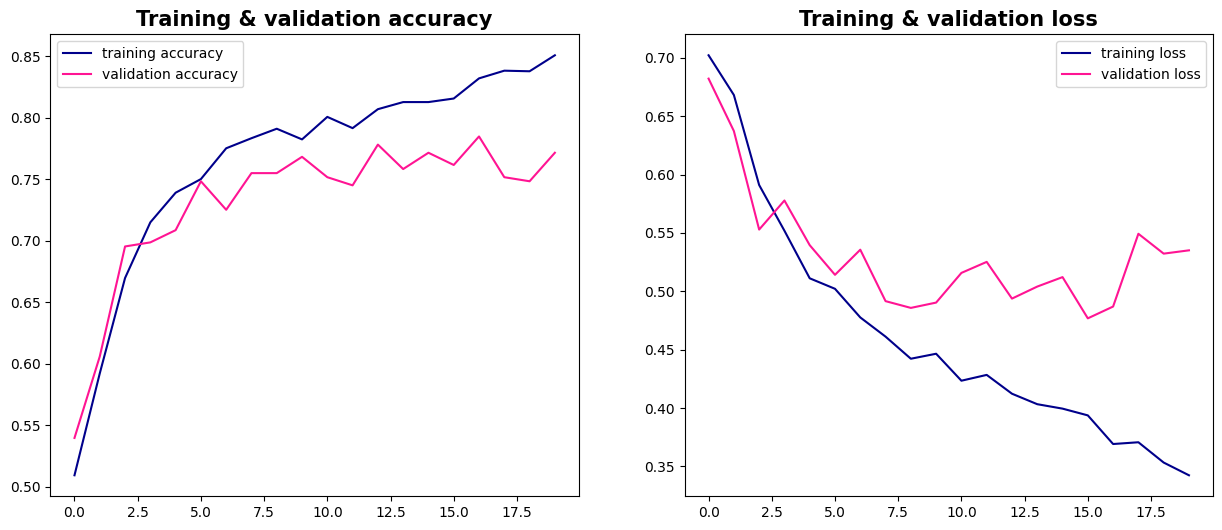

In [34]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize the dictionary to store metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 80)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.cpu().numpy())
                
                print('{}: \t *** \t Loss: {:.4f} \t *** \t Acc: {:.4f} \t *** \t lr: {:.8f}'.format(
                    phase, epoch_loss, epoch_acc, optimizer.param_groups[0]['lr']))
                
                scheduler.step()
                
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.cpu().numpy())
                
                print('{}: \t *** \t Loss: {:.4f} \t *** \t Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    print()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs)
draw_plot(history)

## *Evaluation:*

In [35]:
model.eval()  # Set the model to evaluation mode

running_corrects = 0

y_pred = []
y_test = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)

        y_pred.extend(preds.cpu().numpy())
        y_test.extend(labels.cpu().numpy())

y_pred = np.asarray(y_pred)
y_test = np.asarray(y_test)

test_acc = running_corrects.double() / len(test_loader.dataset)
print('Test Acc: {:.4f}'.format(test_acc))

Test Acc: 0.7878


## *Calculate classification report:*

In [36]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')

Precision: 0.789578
Recall: 0.787776


In [37]:
report = classification_report(y_test, y_pred, target_names=['normal', 'fracture'])
print(report)

              precision    recall  f1-score   support

      normal       0.81      0.76      0.78       301
    fracture       0.76      0.82      0.79       288

    accuracy                           0.79       589
   macro avg       0.79      0.79      0.79       589
weighted avg       0.79      0.79      0.79       589



## *Compute confusion matrix:*

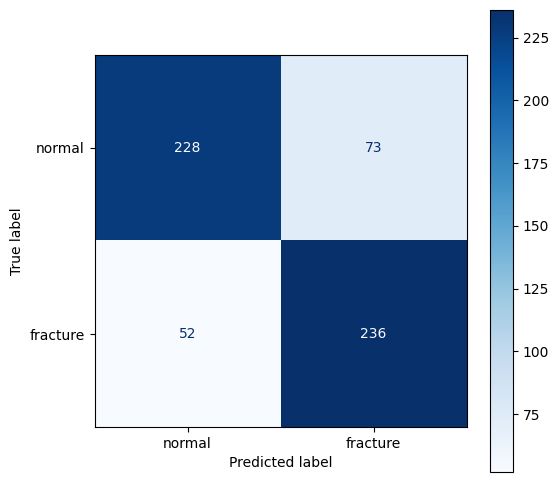

In [38]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['normal', 'fracture']

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(6, 6))
display.plot(ax=ax, values_format='.4g', cmap='Blues')
plt.show()

In [39]:
auc_metric = roc_auc_score(y_test, y_pred)
print("AUC:", auc_metric)

AUC: 0.7884597637504613


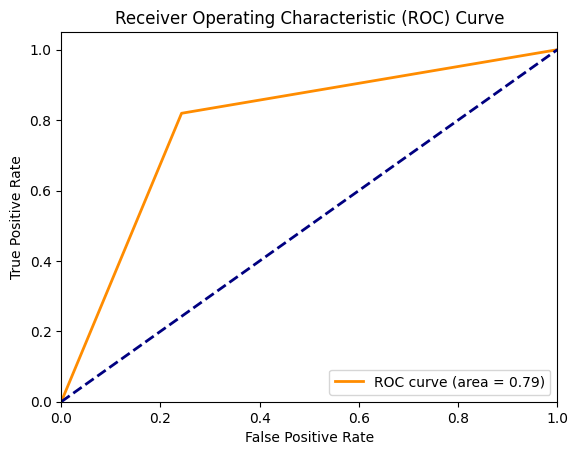

In [40]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Swin (base) Transformer:

In [12]:
from transformers import AutoImageProcessor, Swinv2ForImageClassification

# Define the model
class SwinClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SwinClassifier, self).__init__()
        self.swin = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=num_classes)
    
    def forward(self, x):
        return self.swin(x)

# Instantiate the model
num_classes = 2
model = SwinClassifier(num_classes)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = Adamax(model.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

num_epochs = 20

In [15]:
from torch.utils.data import Dataset, DataLoader

# Define the transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0, hue=0),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom dataset to apply transformations
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        try:
            image = self.images[idx]
            label = self.labels[idx]
            if self.transform:
                image = Image.fromarray(image.astype('uint8'), 'RGB')  # Ensure the image is in the correct format
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            raise

# Convert your data into PyTorch tensors
X_train_tensor = np.array(X_train, dtype=np.uint8)  
y_train_tensor = np.array(y_train, dtype=np.int64)
X_val_tensor = np.array(X_val, dtype=np.uint8)
y_val_tensor = np.array(y_val, dtype=np.int64)
X_test_tensor = np.array(X_test, dtype=np.uint8)
y_test_tensor = np.array(y_test, dtype=np.int64)

# Create datasets
train_dataset = CustomDataset(X_train_tensor, y_train_tensor, transform=train_transform)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor, transform=val_test_transform)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


Epoch 1/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.7014 	 *** 	 Acc: 0.4993 	 *** 	 lr: 0.00010000
val: 	 *** 	 Loss: 0.6867 	 *** 	 Acc: 0.6258

Epoch 2/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.6559 	 *** 	 Acc: 0.6062 	 *** 	 lr: 0.00010000
val: 	 *** 	 Loss: 0.5645 	 *** 	 Acc: 0.6954

Epoch 3/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.5889 	 *** 	 Acc: 0.6923 	 *** 	 lr: 0.00010000
val: 	 *** 	 Loss: 0.5308 	 *** 	 Acc: 0.7550

Epoch 4/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.5277 	 *** 	 Acc: 0.7338 	 *** 	 lr: 0.00010000
val: 	 *** 	 Loss: 0.4865 	 *** 	 Acc: 0.7649

Epoch 5/20
--------------------------------------------------------------------------------
train: 	 *** 	 Loss: 0.5216 	 *** 	 Acc: 0.7333 	 *** 	 lr: 0.000100

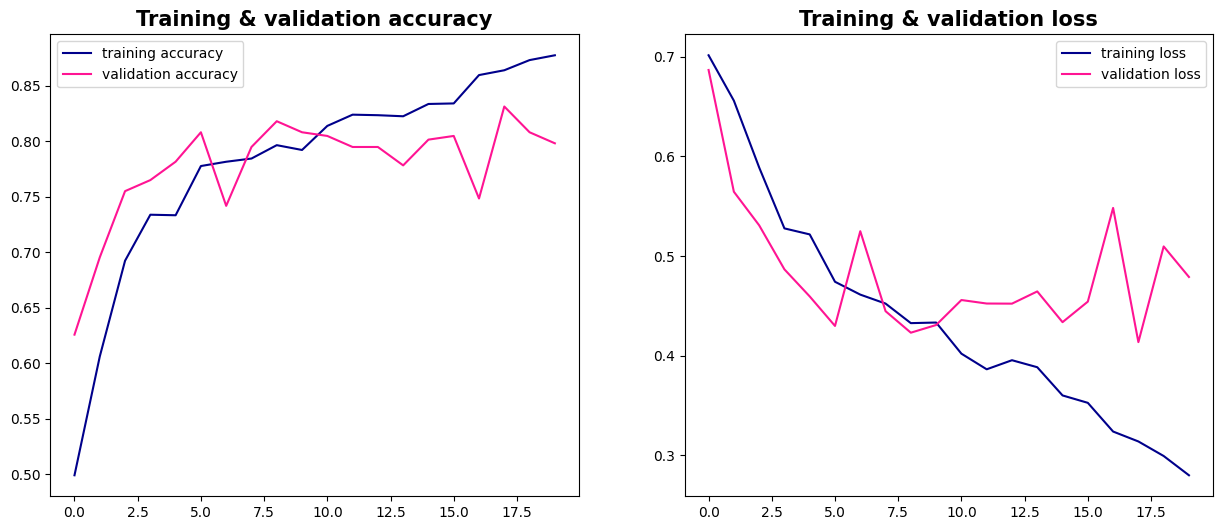

In [17]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize the dictionary to store metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 80)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.cpu().numpy())
                
                print('{}: \t *** \t Loss: {:.4f} \t *** \t Acc: {:.4f} \t *** \t lr: {:.8f}'.format(
                    phase, epoch_loss, epoch_acc, optimizer.param_groups[0]['lr']))
                
#                 scheduler.step()
                
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.cpu().numpy())
                
                print('{}: \t *** \t Loss: {:.4f} \t *** \t Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    print()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs)
draw_plot(history)

## *Evaluation:*

In [18]:
model.eval()  # Set the model to evaluation mode

running_corrects = 0

y_pred = []
y_test = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)

        y_pred.extend(preds.cpu().numpy())
        y_test.extend(labels.cpu().numpy())

y_pred = np.asarray(y_pred)
y_test = np.asarray(y_test)

test_acc = running_corrects.double() / len(test_loader.dataset)
print('Test Acc: {:.4f}'.format(test_acc))

Test Acc: 0.7997


## *Calculate classification report:*

In [21]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')

Precision: 0.799644
Recall: 0.799660


In [22]:
report = classification_report(y_test, y_pred, target_names=['normal', 'fracture'])
print(report)

              precision    recall  f1-score   support

      normal       0.80      0.81      0.80       301
    fracture       0.80      0.79      0.79       288

    accuracy                           0.80       589
   macro avg       0.80      0.80      0.80       589
weighted avg       0.80      0.80      0.80       589



## *Compute confusion matrix:*

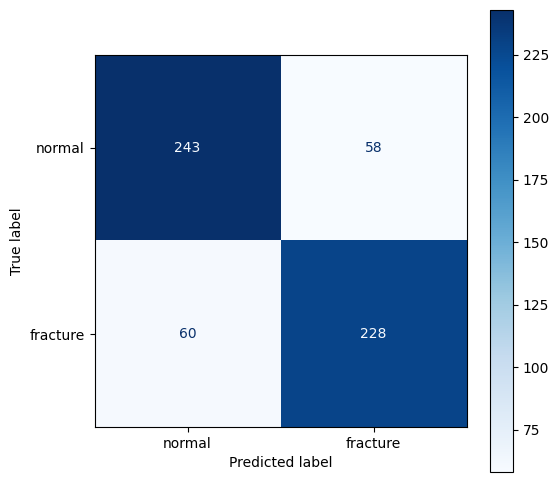

In [19]:
cm = confusion_matrix(y_test, y_pred)

class_labels = ['normal', 'fracture']

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(6, 6))
display.plot(ax=ax, values_format='.4g', cmap='Blues')
plt.show()

In [20]:
auc_metric = roc_auc_score(y_test, y_pred)
print("AUC:", auc_metric)

AUC: 0.7994878183831671


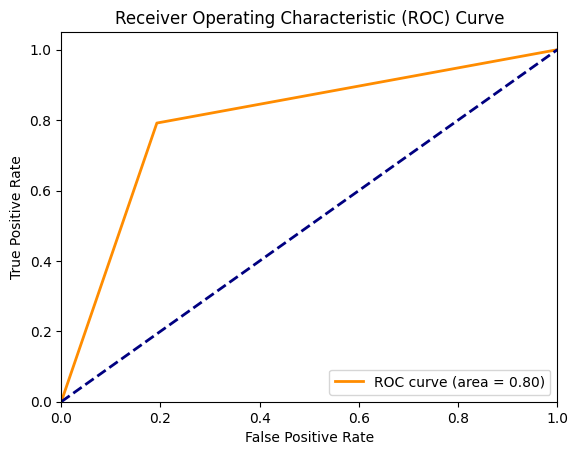

In [23]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## *Save Model:*

In [ ]:
# Save the entire model
torch.save(model, 'best_model_entire.pth')